### 1. Data preprocessing

In [19]:
import pandas as pd
import sys
import os

def create_dataframe(path):
    df = pd.read_excel(path)
    return df

def delete_duplicates(df):
    # Stergerea duplicatelor
    df.drop_duplicates(inplace = True) # inplace = True indica faptul ca fuctia va sterge duplicate din dataframe-ul dat si nu va return unul nou
    return df

def remove_unknown_gender_instances(df):
    # Eliminăm rândurile unde 'Gender' are valoarea 'Unknown'
    return df[df['Gender'] != 'Unknown']

def remove_unknown_race_instances(df):
    # Eliminăm rândurile unde 'Race' are valoarea 'Unknown'
    return df[df['Race'] != 'Unknown']

def replace_unknown_with_median(x):
    # Înlocuiește "Unknown" cu mediană, după ce valorile sunt convertite în numeric
    median_value = pd.to_numeric(x[x != "Unknown"]).median()
    return x.replace("Unknown", median_value)

# Funcția pentru aplicarea pe grupuri
def edit_unknown_values_for_natural_area(df):
    df["The abundance of natural areas"] = df.groupby("Race")["The abundance of natural areas"].transform(
        lambda x: replace_unknown_with_median(x)
    )

    # Convertim în int
    df["The abundance of natural areas"] = df["The abundance of natural areas"].astype(int)
    return df

def encode_age(df):
    # Create a copy of the DataFrame
    df_transformed = df.copy()
    
    # Age mapping
    age_mapping = {
        'Less than 1 year': 0.5,
        '1-2 years': 1.5,
        '2-10 years': 6,
        'More than 10 years': 12
    }
    
    # Apply age mapping
    df_transformed['Age'] = df_transformed['Age'].map(age_mapping)
    
    return df_transformed

def encode_categorical_columns(df, categorical_columns):
    # Create one-hot encoded columns
    for column in categorical_columns:
        one_hot = pd.get_dummies(df[column], prefix=column)
        
        # Add one-hot encoded columns to the transformed DataFrame
        df = pd.concat([df, one_hot], axis=1)
        
        # Drop the original categorical column
        df = df.drop(column, axis=1)
    
    return df


def preprocessing():
    # Crearea dataframe-ului
    df = create_dataframe('./Dataset/Dataset.xlsx')

    #stergerea duplicatelor
    df = delete_duplicates(df)

    # Stergerea instantelor unde Gender = Unknown (6 instante)
    df = remove_unknown_gender_instances(df)

    # Stergerea instantelor unde Race = Unknown (79 instante)
    df = remove_unknown_race_instances(df)

    # modificam instantele ce au valori 'Unknown' pentru coloana 'The abundance of natural areas' in mediana pentru fiecare rasa (240 de instante)
    df = edit_unknown_values_for_natural_area(df)

    # encodam coloana 'Age'
    df = encode_age(df)

    return df

df = preprocessing()
df.info()
# Print current path



<class 'pandas.core.frame.DataFrame'>
Index: 3055 entries, 0 to 3142
Data columns (total 26 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Gender                              3055 non-null   object 
 1   Age                                 3055 non-null   float64
 2   Race                                3055 non-null   object 
 3   Number of cats in the household     3055 non-null   int64  
 4   Type of housing                     3055 non-null   object 
 5   Zone                                3055 non-null   object 
 6   Time spent outside each day         3055 non-null   int64  
 7   Time spent with the owner each day  3055 non-null   int64  
 8   Shy                                 3055 non-null   int64  
 9   Calm                                3055 non-null   int64  
 10  Skittish                            3055 non-null   int64  
 11  Intelligent                         3055 non-nul

### 2. Data splitting

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def create_single_race_column(df):
    """
    Convert one-hot encoded race columns into a single categorical column.
    Returns the race column and the original dataframe.
    """
    # Get all race column names
    race_columns = [col for col in df.columns if col.startswith('Race_')]
    
    # Create a single race column
    race_series = pd.Series('Unknown', index=df.index)
    for col in race_columns:
        # For each True value, set the race name (removing 'Race_' prefix)
        race_series[df[col]] = col.replace('Race_', '')
    
    return race_series

def split_cat_dataset(df, test_size=0.1, random_state=42):
    """
    Perform stratified split on the cat dataset based on races.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing cat data
    test_size : float
        Proportion of the dataset to include in the test split
    random_state : int
        Random state for reproducibility
    
    Returns:
    --------
    train_df, test_df : tuple of pandas.DataFrame
        The split datasets
    """
    # Create single race column for stratification
    race_column = create_single_race_column(df)
    
    # Perform stratified split
    train_idx, test_idx = train_test_split(
        np.arange(len(df)),
        test_size=test_size,
        random_state=random_state,
        stratify=race_column
    )
    
    # Split the dataframe
    train_df = df.iloc[train_idx].copy()
    test_df = df.iloc[test_idx].copy()
    
    # Print split information
    print(f"Training set size: {len(train_df)} ({(1-test_size)*100:.1f}%)")
    print(f"Test set size: {len(test_df)} ({test_size*100:.1f}%)")
    
    # Verify stratification
    print("\nRace distribution in original dataset:")
    original_dist = race_column.value_counts(normalize=True)
    print(original_dist)
    
    print("\nRace distribution in training set:")
    train_dist = create_single_race_column(train_df).value_counts(normalize=True)
    print(train_dist)
    
    print("\nRace distribution in test set:")
    test_dist = create_single_race_column(test_df).value_counts(normalize=True)
    print(test_dist)
    
    return train_df, test_df

# One-hot encode categorical variables
categorical_columns = ['Type of housing', 'Zone', 'Race', 'Gender']
df = encode_categorical_columns(df, categorical_columns)

# Split the dataset
train_df, test_df = split_cat_dataset(df, test_size=0.1, random_state=42)

Training set size: 2749 (90.0%)
Test set size: 306 (10.0%)

Race distribution in original dataset:
European             0.333224
No breed             0.157774
Bengal               0.077905
Ragdoll              0.070704
Maine coon           0.064484
Birman               0.062848
Persian              0.062848
British Shorthair    0.054337
Other                0.044190
Sphynx               0.024877
Siamese              0.018985
Chartreux            0.010147
Turkish angora       0.009165
Savannah             0.008511
Name: proportion, dtype: float64

Race distribution in training set:
European             0.333212
No breed             0.157876
Bengal               0.077846
Ragdoll              0.070571
Maine coon           0.064387
Birman               0.062932
Persian              0.062932
British Shorthair    0.054202
Other                0.044380
Sphynx               0.024736
Siamese              0.018916
Chartreux            0.010186
Turkish angora       0.009094
Savannah             0

### 3. Training the model

> Antrenarea pe setul de date cu modificări minime.


Fold 1/6
Epoch 5/1000
Train Loss: 2.3409, Train Acc: 0.2860
Val Loss: 2.3097, Val Acc: 0.2941
Epoch 10/1000
Train Loss: 2.2030, Train Acc: 0.3111
Val Loss: 2.2118, Val Acc: 0.3028
Epoch 15/1000
Train Loss: 2.1427, Train Acc: 0.3139
Val Loss: 2.1686, Val Acc: 0.2985
Epoch 20/1000
Train Loss: 2.0865, Train Acc: 0.3195
Val Loss: 2.1410, Val Acc: 0.3094
Epoch 25/1000
Train Loss: 2.0622, Train Acc: 0.3318
Val Loss: 2.1266, Val Acc: 0.3137
Epoch 30/1000
Train Loss: 2.0286, Train Acc: 0.3517
Val Loss: 2.1162, Val Acc: 0.3072
Epoch 35/1000
Train Loss: 2.0156, Train Acc: 0.3456
Val Loss: 2.1084, Val Acc: 0.3181
Epoch 40/1000
Train Loss: 1.9889, Train Acc: 0.3525
Val Loss: 2.1028, Val Acc: 0.3224
Epoch 45/1000
Train Loss: 1.9688, Train Acc: 0.3610
Val Loss: 2.0994, Val Acc: 0.3224
Epoch 50/1000
Train Loss: 1.9504, Train Acc: 0.3628
Val Loss: 2.0960, Val Acc: 0.3181
Epoch 55/1000
Train Loss: 1.9427, Train Acc: 0.3616
Val Loss: 2.0936, Val Acc: 0.3159
Epoch 60/1000
Train Loss: 1.9275, Train Acc: 

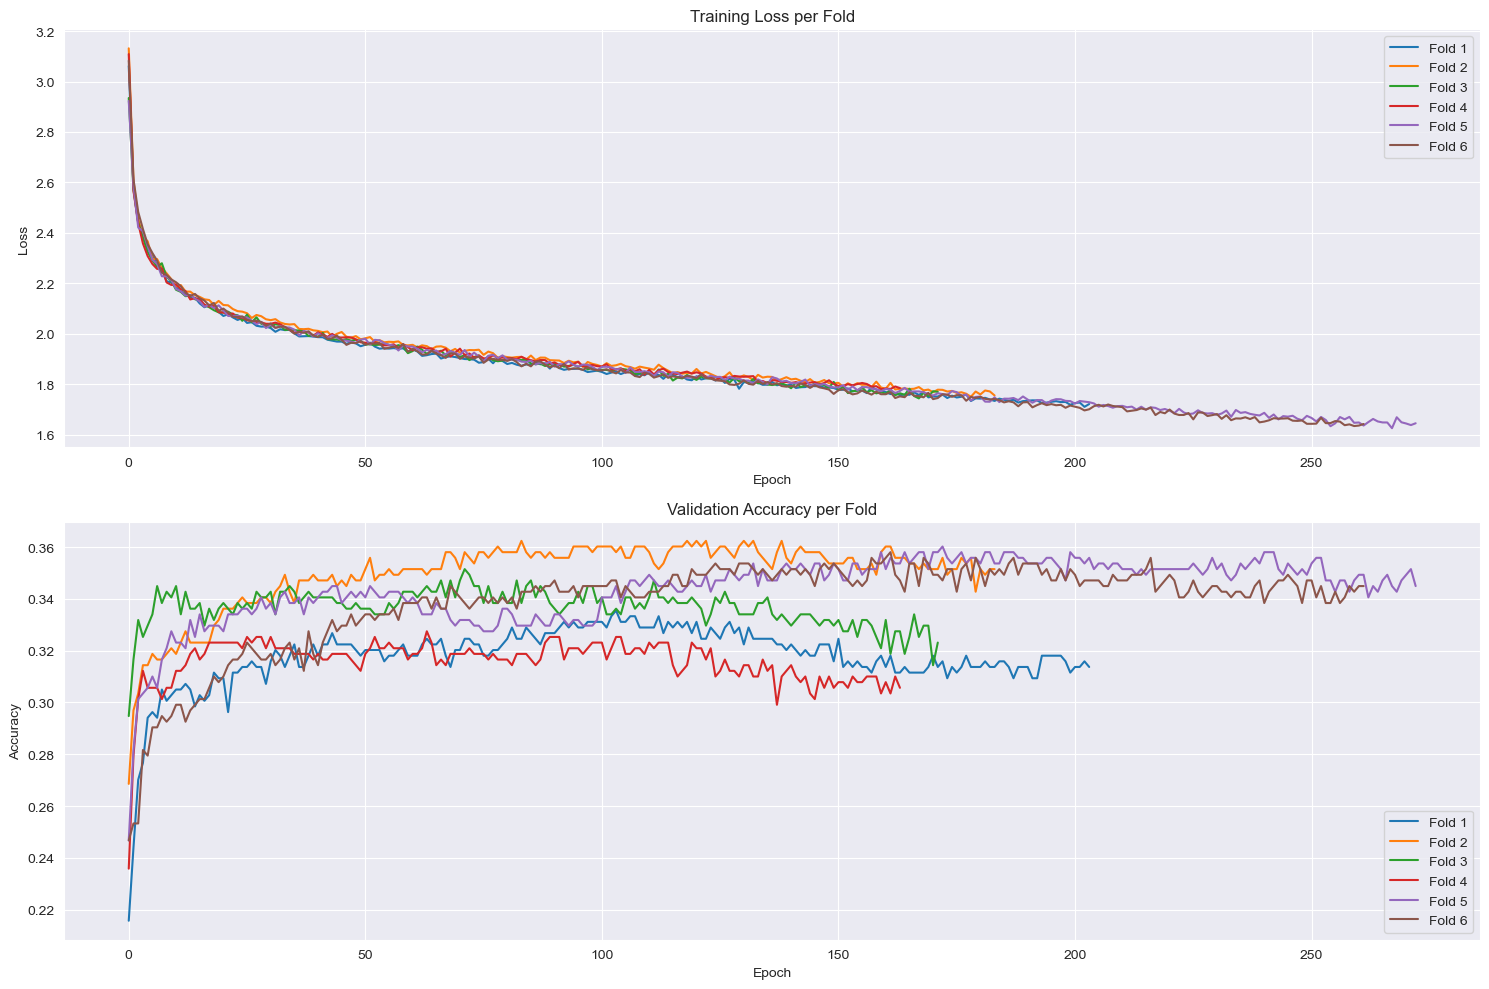

In [11]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

class Dropout:
    def __init__(self, dropout_rate):
        self.dropout_rate = dropout_rate
        self.mask = None
        
    def forward(self, input_data, training=True):
        if training:
            self.mask = np.random.binomial(1, 1 - self.dropout_rate, input_data.shape) / (1 - self.dropout_rate)
            return input_data * self.mask
        return input_data
    
    def backward(self, grad_output):
        return grad_output * self.mask

class Layer:
    def __init__(self, input_size, output_size, activation='relu', l2_lambda=0.005, dropout_rate=0.2):
        self.weights = np.random.randn(input_size, output_size) * np.sqrt(2.0/input_size)
        self.bias = np.zeros((1, output_size))
        self.activation = activation
        self.l2_lambda = l2_lambda
        self.dropout = Dropout(dropout_rate)
        self.input = None
        self.output = None
        self.z = None
    
    def get_weights(self):
        return {
            'weights': self.weights.copy(),
            'bias': self.bias.copy()
        }
    
    def set_weights(self, weights):
        self.weights = weights['weights'].copy()
        self.bias = weights['bias'].copy()
        
    def forward(self, input_data, training=True):
        self.input = input_data
        self.z = np.dot(input_data, self.weights) + self.bias
        
        if self.activation == 'relu':
            self.output = np.maximum(0, self.z)
        elif self.activation == 'softmax':
            exp_values = np.exp(self.z - np.max(self.z, axis=1, keepdims=True))
            self.output = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        
        if self.activation != 'softmax':
            self.output = self.dropout.forward(self.output, training)
            
        return self.output
    
    def backward(self, grad_output, learning_rate):
        if self.activation != 'softmax':
            grad_output = self.dropout.backward(grad_output)
        
        if self.activation == 'relu':
            grad_z = grad_output * (self.z > 0)
        elif self.activation == 'softmax':
            grad_z = grad_output
            
        grad_weights = np.dot(self.input.T, grad_z) + self.l2_lambda * self.weights
        grad_bias = np.sum(grad_z, axis=0, keepdims=True)
        grad_input = np.dot(grad_z, self.weights.T)
        
        self.weights -= learning_rate * grad_weights
        self.bias -= learning_rate * grad_bias
        
        return grad_input

class NeuralNetwork:
    def __init__(self, input_dim, output_dim, l2_lambda=0.005):
        self.layers = [
            Layer(input_dim, 128, 'relu', l2_lambda, dropout_rate=0.1),
            Layer(128, 64, 'relu', l2_lambda, dropout_rate=0.1),
            Layer(64, output_dim, 'softmax', l2_lambda, dropout_rate=0.0)
        ]
    
    def get_weights(self):
        return [layer.get_weights() for layer in self.layers]
    
    def set_weights(self, weights):
        for layer, w in zip(self.layers, weights):
            layer.set_weights(w)
    
    def forward(self, X, training=True):
        current_output = X
        for layer in self.layers:
            current_output = layer.forward(current_output, training)
        return current_output
    
    def backward(self, X, y, learning_rate):
        grad_output = self.layers[-1].output - y
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output, learning_rate)
    
    def train_step(self, X_batch, y_batch, learning_rate):
        predictions = self.forward(X_batch, training=True)
        self.backward(X_batch, y_batch, learning_rate)
        loss = self.compute_loss(predictions, y_batch)
        return loss, predictions
    
    def predict(self, X):
        return self.forward(X, training=False)
    
    def compute_loss(self, predictions, y_true):
        epsilon = 1e-15
        predictions = np.clip(predictions, epsilon, 1 - epsilon)
        return -np.mean(np.sum(y_true * np.log(predictions), axis=1))
    
    def compute_accuracy(self, predictions, y_true):
        return np.mean(np.argmax(predictions, axis=1) == np.argmax(y_true, axis=1))

def plot_training_history(histories, n_splits):
    plt.figure(figsize=(15, 10))
    
    # Plot training loss
    plt.subplot(2, 1, 1)
    for fold in range(n_splits):
        plt.plot(histories[fold]['train_loss'], label=f'Fold {fold+1}')
    plt.title('Training Loss per Fold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot validation accuracy
    plt.subplot(2, 1, 2)
    for fold in range(n_splits):
        plt.plot(histories[fold]['val_acc'], label=f'Fold {fold+1}')
    plt.title('Validation Accuracy per Fold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
def train_and_evaluate_model(X, y, n_splits=6, epochs=1000, batch_size=32, learning_rate=0.0001, patience=100):
    y_encoded = y.values
    scaler = StandardScaler()
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_results = []
    histories = []
    
    n_classes = y_encoded.shape[1]
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, np.argmax(y_encoded, axis=1)), 1):
        print(f"\nFold {fold}/{n_splits}")
        
        X_train, X_val = X.iloc[train_idx].values, X.iloc[val_idx].values
        y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]
        
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        model = NeuralNetwork(X_train.shape[1], n_classes, 0.001)
        
        history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
        }
        
        best_val_accuracy = 0
        best_weights = None
        best_epoch = 0
        patience_counter = 0
        
        for epoch in range(epochs):
            indices = np.random.permutation(len(X_train_scaled))
            X_train_shuffled = X_train_scaled[indices]
            y_train_shuffled = y_train[indices]
            
            epoch_train_loss = 0
            epoch_train_acc = 0
            n_batches = 0
            
            for i in range(0, len(X_train_scaled), batch_size):
                X_batch = X_train_shuffled[i:i+batch_size]
                y_batch = y_train_shuffled[i:i+batch_size]
                
                loss, predictions = model.train_step(X_batch, y_batch, learning_rate)
                accuracy = model.compute_accuracy(predictions, y_batch)
                
                epoch_train_loss += loss
                epoch_train_acc += accuracy
                n_batches += 1
            
            avg_train_loss = epoch_train_loss / n_batches
            avg_train_acc = epoch_train_acc / n_batches
            
            val_predictions = model.predict(X_val_scaled)
            val_loss = model.compute_loss(val_predictions, y_val)
            val_accuracy = model.compute_accuracy(val_predictions, y_val)
            
            history['train_loss'].append(avg_train_loss)
            history['train_acc'].append(avg_train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_accuracy)
            
            # Early stopping logic
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_weights = model.get_weights()
                best_epoch = epoch
                patience_counter = 0
            else:
                patience_counter += 1
                
            if patience_counter >= patience:
                print(f"\nEarly stopping triggered at epoch {epoch + 1}")
                print(f"No improvement in validation accuracy for {patience} epochs")
                break
            
            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch + 1}/{epochs}")
                print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}")
                print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
        
        # Restore best weights for this fold
        model.set_weights(best_weights)
        histories.append(history)
        
        fold_results.append({
            'fold': fold,
            'best_val_accuracy': best_val_accuracy,
            'best_epoch': best_epoch,
            'model': model
        })
        
        print(f"\nFold {fold} Best Results:")
        print(f"Best Epoch: {best_epoch}")
        print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
    
    # Find the best overall model
    best_fold = max(fold_results, key=lambda x: x['best_val_accuracy'])
    
    print("\nOverall Cross-validation results:")
    print(f"Mean validation accuracy: {np.mean([r['best_val_accuracy'] for r in fold_results]):.4f}")
    print(f"Standard deviation: {np.std([r['best_val_accuracy'] for r in fold_results]):.4f}")
    print(f"\nBest model from fold {best_fold['fold']} at epoch {best_fold['best_epoch']}")
    print(f"Best validation accuracy: {best_fold['best_val_accuracy']:.4f}")
    
    # Plot training history
    plot_training_history(histories, n_splits)
    
    return best_fold['model'], fold_results, histories



def prepare_data(data):
    race_columns = [col for col in data.columns if col.startswith('Race_')]
    X = data.drop(columns=race_columns)
    y = data[race_columns]
    return X, y

def main(data):
    X, y = prepare_data(data)
    best_model, fold_results, histories = train_and_evaluate_model(X, y)
    return best_model, fold_results, histories

best_model, accuracies, histories = main(train_df)

C:\Users\mihai\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mihai\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mihai\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Model Evaluation on Test Data ===

Overall Test Accuracy: 0.3529

Classification Report:
                   precision    recall  f1-score   support

           Bengal       0.29      0.17      0.21        24
           Birman       0.33      0.05      0.09        19
British Shorthair       0.00      0.00      0.00        17
        Chartreux       0.00      0.00      0.00         3
         European       0.38      0.95      0.55       102
       Maine coon       0.00      0.00      0.00        20
         No breed       0.00      0.00      0.00        48
            Other       0.00      0.00      0.00        13
          Persian       0.00      0.00      0.00        19
          Ragdoll       0.30      0.27      0.29        22
         Savannah       0.00      0.00      0.00         2
          Siamese       0.00      0.00      0.00         6
           Sphynx       0.00      0.00      0.00         8
   Turkish angora       0.00      0.00      0.00         3

         accuracy  

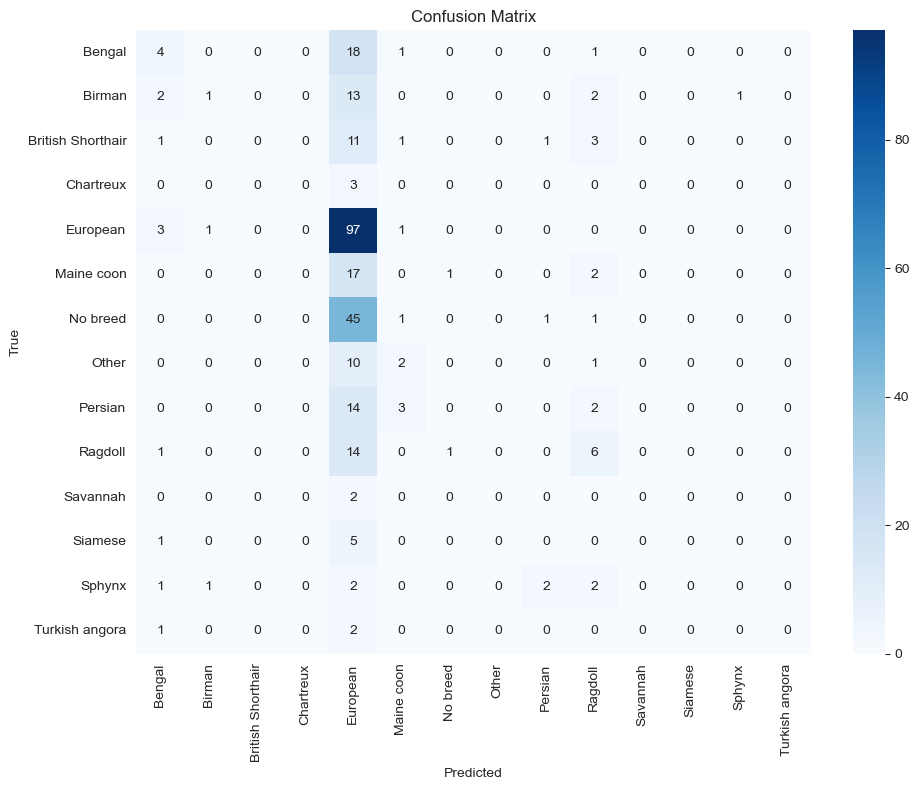

In [12]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def test_model(best_model, test_df):
    """
    Test the trained model on a new test dataset.
    
    Parameters:
    best_model: trained Keras model
    test_df: pandas DataFrame containing test data
    
    Returns:
    dict containing test accuracy, predictions, and evaluation metrics
    """
    # Prepare test data
    race_columns = [col for col in test_df.columns if col.startswith('Race_')]
    X_test = test_df.drop(columns=race_columns)
    y_test = test_df[race_columns]
    
    # Scale features using the same approach as training
    scaler = StandardScaler()
    X_test_scaled = scaler.fit_transform(X_test)
    
    # Make predictions
    y_pred_proba = best_model.predict(X_test_scaled)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_test_classes = np.argmax(y_test.values, axis=1)
    
    # Calculate accuracy
    test_accuracy = np.mean(y_pred == y_test_classes)
    
    # Generate classification report
    class_names = [col.replace('Race_', '') for col in race_columns]
    report = classification_report(y_test_classes, y_pred, target_names=class_names)
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test_classes, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    
    # Calculate per-class metrics
    per_class_metrics = {}
    for i, class_name in enumerate(class_names):
        true_class = (y_test_classes == i)
        pred_class = (y_pred == i)
        
        true_positives = np.sum(true_class & pred_class)
        false_positives = np.sum(~true_class & pred_class)
        false_negatives = np.sum(true_class & ~pred_class)
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        per_class_metrics[class_name] = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
    
    return {
        'test_accuracy': test_accuracy,
        'classification_report': report,
        'confusion_matrix': cm,
        'per_class_metrics': per_class_metrics,
        'predictions': y_pred,
        'prediction_probabilities': y_pred_proba
    }

# Example usage
def evaluate_test_results(test_df, best_model):
    """
    Evaluate and print test results in a readable format.
    """
    results = test_model(best_model, test_df)
    
    print("\n=== Model Evaluation on Test Data ===")
    print(f"\nOverall Test Accuracy: {results['test_accuracy']:.4f}")
    
    print("\nClassification Report:")
    print(results['classification_report'])
    
    print("\nPer-Class Metrics:")
    for class_name, metrics in results['per_class_metrics'].items():
        print(f"\n{class_name}:")
        for metric_name, value in metrics.items():
            print(f"  {metric_name}: {value:.4f}")
    
    return results

# To use the testing script:
results = evaluate_test_results(test_df, best_model)

In [20]:
import numpy as np

# Definim lungimi posibile ale părului pentru fiecare categorie
hair_length_mapping = {
    'Sphynx': ['No hair'],
    'Siamese': ['Short hair', 'Medium hair'],
    'British Shorthair': ['Short hair'],
    'Bengal': ['Short hair'],
    'Chartreux': ['Short hair'],
    'Savannah': ['Short hair'],
    'European': ['Short hair', 'Medium hair'],
    'Birman': ['Medium hair', 'Long hair'],
    'Turkish angora': ['Medium hair', 'Long hair'],
    'Persian': ['Long hair'],
    'Maine coon': ['Long hair'],
    'Ragdoll': ['Medium hair', 'Long hair'],
    'No breed': ['Short hair', 'Medium hair'],
    'Other': ['Short hair', 'Medium hair']
}

# Funcție pentru a selecta aleator lungimea părului bazat pe rasa specifică
def assign_coat_length(race):
    if race in hair_length_mapping:
        return np.random.choice(hair_length_mapping[race])
    return "Unknown"  # Default, în cazul în care rasa nu este cunoscută

# Aplicăm funcția pentru fiecare instanță
df['Coat Length'] = df['Race'].apply(assign_coat_length)

In [21]:
# Definirea caracteristicilor legate de coat pattern pentru fiecare rasă
coat_patterns = {
    "European": ["Tabby", "Solid", "Bicolor", "Tortoiseshell"],
    "Bengal": ["Tabby"],
    "Ragdoll": ["Colorpoint"],
    "Maine coon": ["Tabby", "Bicolor"],
    "Birman": ["Colorpoint"],
    "Persian": ["Colorpoint"],
    "British Shorthair": ["Solid", "Tabby", "Tortoiseshell"],
    "Sphynx": ["Solid", "Tabby"],
    "Siamese": ["Colorpoint"],
    "Chartreux": ["Solid"],
    "Turkish angora": ["Solid", "Tabby"],
    "Savannah": ["Tabby"],
    "No breed": ["Tabby", "Solid", "Bicolor", "Tricolor", "Tortoiseshell"],
    "Other": ["Tabby", "Solid", "Bicolor"]
}

# Adăugarea caracteristicilor în mod uniform
df["Coat Pattern"] = df["Race"].apply(
    lambda breed: np.random.choice(coat_patterns[breed])  # Atribuim aleatoriu un pattern din lista corespunzătoare
)

print(df)



     Gender   Age        Race  Number of cats in the household  \
0         F   0.5      Birman                                3   
1         F   0.5      Birman                                1   
2         F   6.0    European                                4   
3         F   0.5    European                                1   
4         F   1.5      Birman                                2   
...     ...   ...         ...                              ...   
3138      F   6.0     Persian                                1   
3139      F   0.5  Maine coon                                3   
3140      M  12.0       Other                                1   
3141      M   0.5      Bengal                                1   
3142      F   0.5      Bengal                                5   

                        Type of housing       Zone  \
0             Apartment without balcony      Urban   
1     Apartment with balcony or terrace      Urban   
2                House in a subdivision      

In [22]:
# One-hot encode categorical variables
categorical_columns = ['Type of housing', 'Zone', 'Race', 'Gender', 'Coat Length', 'Coat Pattern']
df = encode_categorical_columns(df, categorical_columns)

# Add FlatFace attribute (True for Persian cats)
df['FlatFace'] = df['Race_Persian']

# Split the dataset
train_df, test_df = split_cat_dataset(df, test_size=0.1, random_state=42)

Training set size: 2749 (90.0%)
Test set size: 306 (10.0%)

Race distribution in original dataset:
European             0.333224
No breed             0.157774
Bengal               0.077905
Ragdoll              0.070704
Maine coon           0.064484
Birman               0.062848
Persian              0.062848
British Shorthair    0.054337
Other                0.044190
Sphynx               0.024877
Siamese              0.018985
Chartreux            0.010147
Turkish angora       0.009165
Savannah             0.008511
Name: proportion, dtype: float64

Race distribution in training set:
European             0.333212
No breed             0.157876
Bengal               0.077846
Ragdoll              0.070571
Maine coon           0.064387
Birman               0.062932
Persian              0.062932
British Shorthair    0.054202
Other                0.044380
Sphynx               0.024736
Siamese              0.018916
Chartreux            0.010186
Turkish angora       0.009094
Savannah             0


Fold 1/6
Epoch 5/1000
Train Loss: 1.8826, Train Acc: 0.4105
Val Loss: 1.7532, Val Acc: 0.4466
Epoch 10/1000
Train Loss: 1.5825, Train Acc: 0.4947
Val Loss: 1.4684, Val Acc: 0.5599
Epoch 15/1000
Train Loss: 1.3888, Train Acc: 0.5508
Val Loss: 1.3044, Val Acc: 0.6078
Epoch 20/1000
Train Loss: 1.2495, Train Acc: 0.6024
Val Loss: 1.1963, Val Acc: 0.6405
Epoch 25/1000
Train Loss: 1.1682, Train Acc: 0.6122
Val Loss: 1.1190, Val Acc: 0.6449
Epoch 30/1000
Train Loss: 1.0989, Train Acc: 0.6189
Val Loss: 1.0629, Val Acc: 0.6471
Epoch 35/1000
Train Loss: 1.0658, Train Acc: 0.6289
Val Loss: 1.0204, Val Acc: 0.6492
Epoch 40/1000
Train Loss: 1.0239, Train Acc: 0.6277
Val Loss: 0.9898, Val Acc: 0.6732
Epoch 45/1000
Train Loss: 0.9841, Train Acc: 0.6451
Val Loss: 0.9661, Val Acc: 0.6688
Epoch 50/1000
Train Loss: 0.9616, Train Acc: 0.6535
Val Loss: 0.9473, Val Acc: 0.6645
Epoch 55/1000
Train Loss: 0.9272, Train Acc: 0.6503
Val Loss: 0.9310, Val Acc: 0.6688
Epoch 60/1000
Train Loss: 0.9131, Train Acc: 

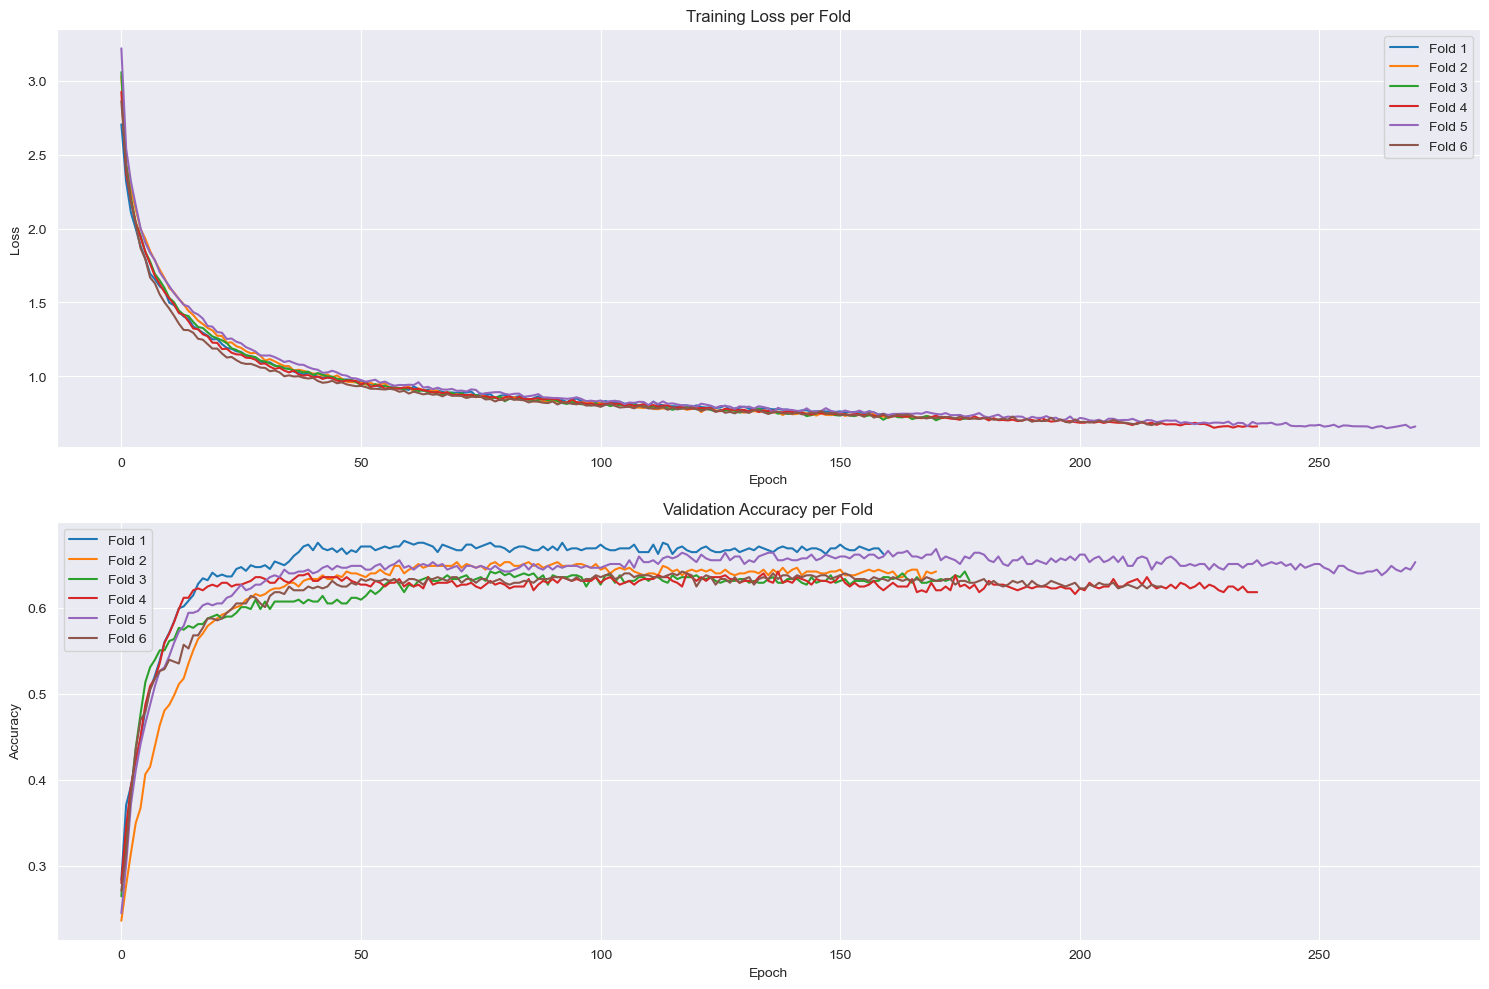

In [23]:
# Train the model
best_model, accuracies, histories = main(train_df)

C:\Users\mihai\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mihai\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mihai\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Model Evaluation on Test Data ===

Overall Test Accuracy: 0.6438

Classification Report:
                   precision    recall  f1-score   support

           Bengal       0.73      0.92      0.81        24
           Birman       0.38      0.42      0.40        19
British Shorthair       0.75      0.35      0.48        17
        Chartreux       0.00      0.00      0.00         3
         European       0.58      0.94      0.72       102
       Maine coon       1.00      1.00      1.00        20
         No breed       1.00      0.15      0.25        48
            Other       0.00      0.00      0.00        13
          Persian       1.00      1.00      1.00        19
          Ragdoll       0.40      0.45      0.43        22
         Savannah       0.00      0.00      0.00         2
          Siamese       1.00      0.17      0.29         6
           Sphynx       1.00      1.00      1.00         8
   Turkish angora       0.00      0.00      0.00         3

         accuracy  

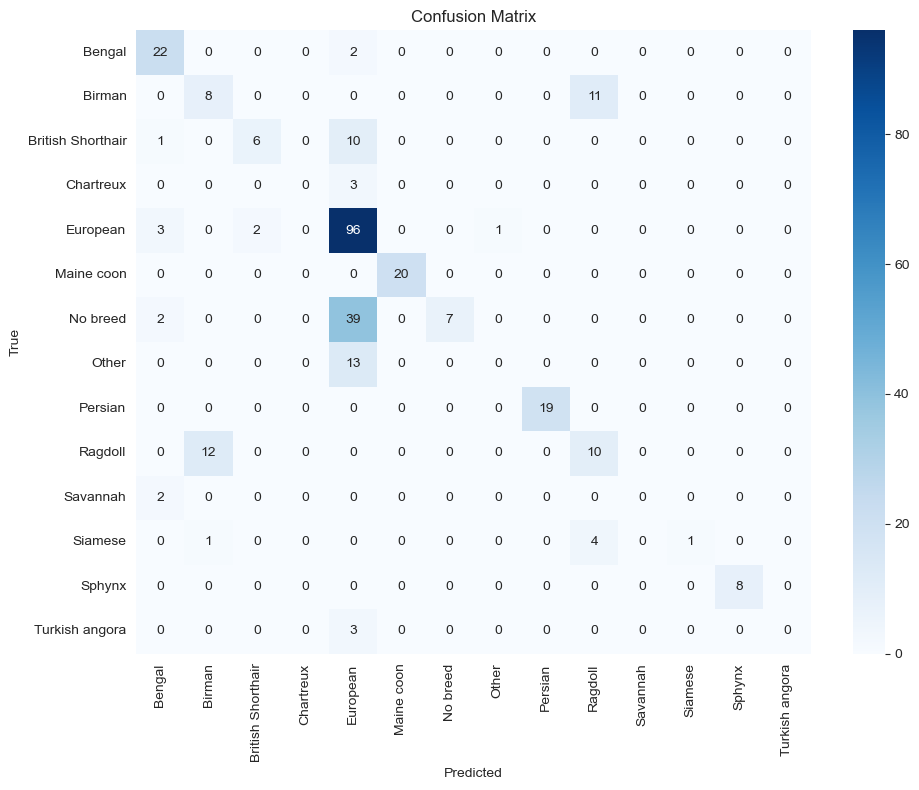

In [24]:
results = evaluate_test_results(test_df, best_model)

> Antrenarea pe setul de date dupa ce au fost eliminati o parte din outliers pentru fiecare rasa si atribut in parte.

In [25]:
import pandas as pd
import numpy as np

def remove_race_outliers(df, percentage=5):
    """
    Remove outliers for each cat race based on numerical columns.
    Shows distribution of races before and after outlier removal.
    
    Parameters:
    df (pandas.DataFrame): Input dataframe
    percentage (float): Percentage of outliers to remove (default 5%)
    
    Returns:
    pandas.DataFrame: DataFrame with outliers removed
    """
    # Get list of race columns and numerical columns
    race_columns = [col for col in df.columns if col.startswith('Race_')]
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    numerical_cols = [col for col in numerical_cols if not col.startswith('Race_')]
    
    # Calculate initial race distribution
    print("\nInitial Race Distribution:")
    initial_dist = {}
    for race_col in race_columns:
        race_count = df[race_col].sum()
        race_pct = (race_count / len(df)) * 100
        initial_dist[race_col.replace('Race_', '')] = (race_count, race_pct)
        print(f"{race_col.replace('Race_', ''):15} {race_count:5d} cats ({race_pct:5.1f}%)")
    
    # Create mask for final filtering
    final_mask = pd.Series(True, index=df.index)
    
    for race_col in race_columns:
        # Get subset of data for this race
        race_mask = df[race_col]
        race_data = df[race_mask]
        
        if len(race_data) == 0:
            continue
            
        # Calculate outlier scores for each numerical column
        outlier_scores = pd.DataFrame()
        
        for col in numerical_cols:
            if race_data[col].nunique() > 1:  # Only process if there's variation
                Q1 = race_data[col].quantile(0.25)
                Q3 = race_data[col].quantile(0.75)
                IQR = Q3 - Q1
                
                # Calculate z-scores for more robust outlier detection
                z_scores = np.abs((race_data[col] - race_data[col].mean()) / race_data[col].std())
                outlier_scores[col] = z_scores
        
        if not outlier_scores.empty:
            # Calculate mean outlier score across all columns
            mean_outlier_score = outlier_scores.mean(axis=1)
            
            # Calculate threshold for given percentage
            threshold = mean_outlier_score.quantile(1 - percentage/100)
            
            # Update final mask
            race_indices = race_data.index[mean_outlier_score <= threshold]
            final_mask.loc[race_mask] = race_data.index.isin(race_indices)
    
    # Apply final mask to remove outliers
    cleaned_df = df[final_mask].copy()
    
    # Print summary of removed records
    removed_count = len(df) - len(cleaned_df)
    print(f"\nRemoved {removed_count} records ({(removed_count/len(df)*100):.1f}% of total)")
    
    # Calculate final race distribution
    print("\nFinal Race Distribution:")
    print("Race            Initial Count (%)    Final Count (%)    Change")
    print("-" * 65)
    for race_col in race_columns:
        race_name = race_col.replace('Race_', '')
        final_count = cleaned_df[race_col].sum()
        final_pct = (final_count / len(cleaned_df)) * 100
        initial_count, initial_pct = initial_dist[race_name]
        change_pct = final_pct - initial_pct
        print(f"{race_name:15} {initial_count:5d} ({initial_pct:5.1f}%)    {final_count:5d} ({final_pct:5.1f}%)    {change_pct:+5.1f}%")
    
    return cleaned_df

# Assuming your DataFrame is called 'df'
df = remove_race_outliers(df, percentage=5)


Initial Race Distribution:
Bengal            238 cats (  7.8%)
Birman            192 cats (  6.3%)
British Shorthair   166 cats (  5.4%)
Chartreux          31 cats (  1.0%)
European         1018 cats ( 33.3%)
Maine coon        197 cats (  6.4%)
No breed          482 cats ( 15.8%)
Other             135 cats (  4.4%)
Persian           192 cats (  6.3%)
Ragdoll           216 cats (  7.1%)
Savannah           26 cats (  0.9%)
Siamese            58 cats (  1.9%)
Sphynx             76 cats (  2.5%)
Turkish angora     28 cats (  0.9%)

Removed 158 records (5.2% of total)

Final Race Distribution:
Race            Initial Count (%)    Final Count (%)    Change
-----------------------------------------------------------------
Bengal            238 (  7.8%)      226 (  7.8%)     +0.0%
Birman            192 (  6.3%)      182 (  6.3%)     -0.0%
British Shorthair   166 (  5.4%)      157 (  5.4%)     -0.0%
Chartreux          31 (  1.0%)       29 (  1.0%)     -0.0%
European         1018 ( 33.3%)      

In [26]:
# Split the dataset
train_df, test_df = split_cat_dataset(df, test_size=0.1, random_state=42)

Training set size: 2607 (90.0%)
Test set size: 290 (10.0%)

Race distribution in original dataset:
European             0.333794
No breed             0.157749
Bengal               0.078012
Ragdoll              0.070763
Maine coon           0.064550
Birman               0.062824
Persian              0.062824
British Shorthair    0.054194
Other                0.044184
Sphynx               0.024853
Siamese              0.018985
Chartreux            0.010010
Turkish angora       0.008975
Savannah             0.008284
Name: proportion, dtype: float64

Race distribution in training set:
European             0.333717
No breed             0.157652
Bengal               0.077867
Ragdoll              0.070963
Maine coon           0.064442
Persian              0.062908
Birman               0.062908
British Shorthair    0.054085
Other                0.044112
Sphynx               0.024933
Siamese              0.019179
Chartreux            0.009973
Turkish angora       0.008822
Savannah             0


Fold 1/6
Epoch 5/1000
Train Loss: 1.9437, Train Acc: 0.3969
Val Loss: 1.7731, Val Acc: 0.4483
Epoch 10/1000
Train Loss: 1.5715, Train Acc: 0.5037
Val Loss: 1.4690, Val Acc: 0.5356
Epoch 15/1000
Train Loss: 1.3912, Train Acc: 0.5691
Val Loss: 1.2907, Val Acc: 0.5655
Epoch 20/1000
Train Loss: 1.2686, Train Acc: 0.5927
Val Loss: 1.1833, Val Acc: 0.5885
Epoch 25/1000
Train Loss: 1.1702, Train Acc: 0.5974
Val Loss: 1.1109, Val Acc: 0.6000
Epoch 30/1000
Train Loss: 1.0910, Train Acc: 0.6333
Val Loss: 1.0606, Val Acc: 0.6161
Epoch 35/1000
Train Loss: 1.0494, Train Acc: 0.6281
Val Loss: 1.0238, Val Acc: 0.6161
Epoch 40/1000
Train Loss: 1.0041, Train Acc: 0.6389
Val Loss: 0.9967, Val Acc: 0.6207
Epoch 45/1000
Train Loss: 0.9755, Train Acc: 0.6443
Val Loss: 0.9750, Val Acc: 0.6184
Epoch 50/1000
Train Loss: 0.9474, Train Acc: 0.6498
Val Loss: 0.9595, Val Acc: 0.6276
Epoch 55/1000
Train Loss: 0.9324, Train Acc: 0.6492
Val Loss: 0.9445, Val Acc: 0.6276
Epoch 60/1000
Train Loss: 0.9037, Train Acc: 

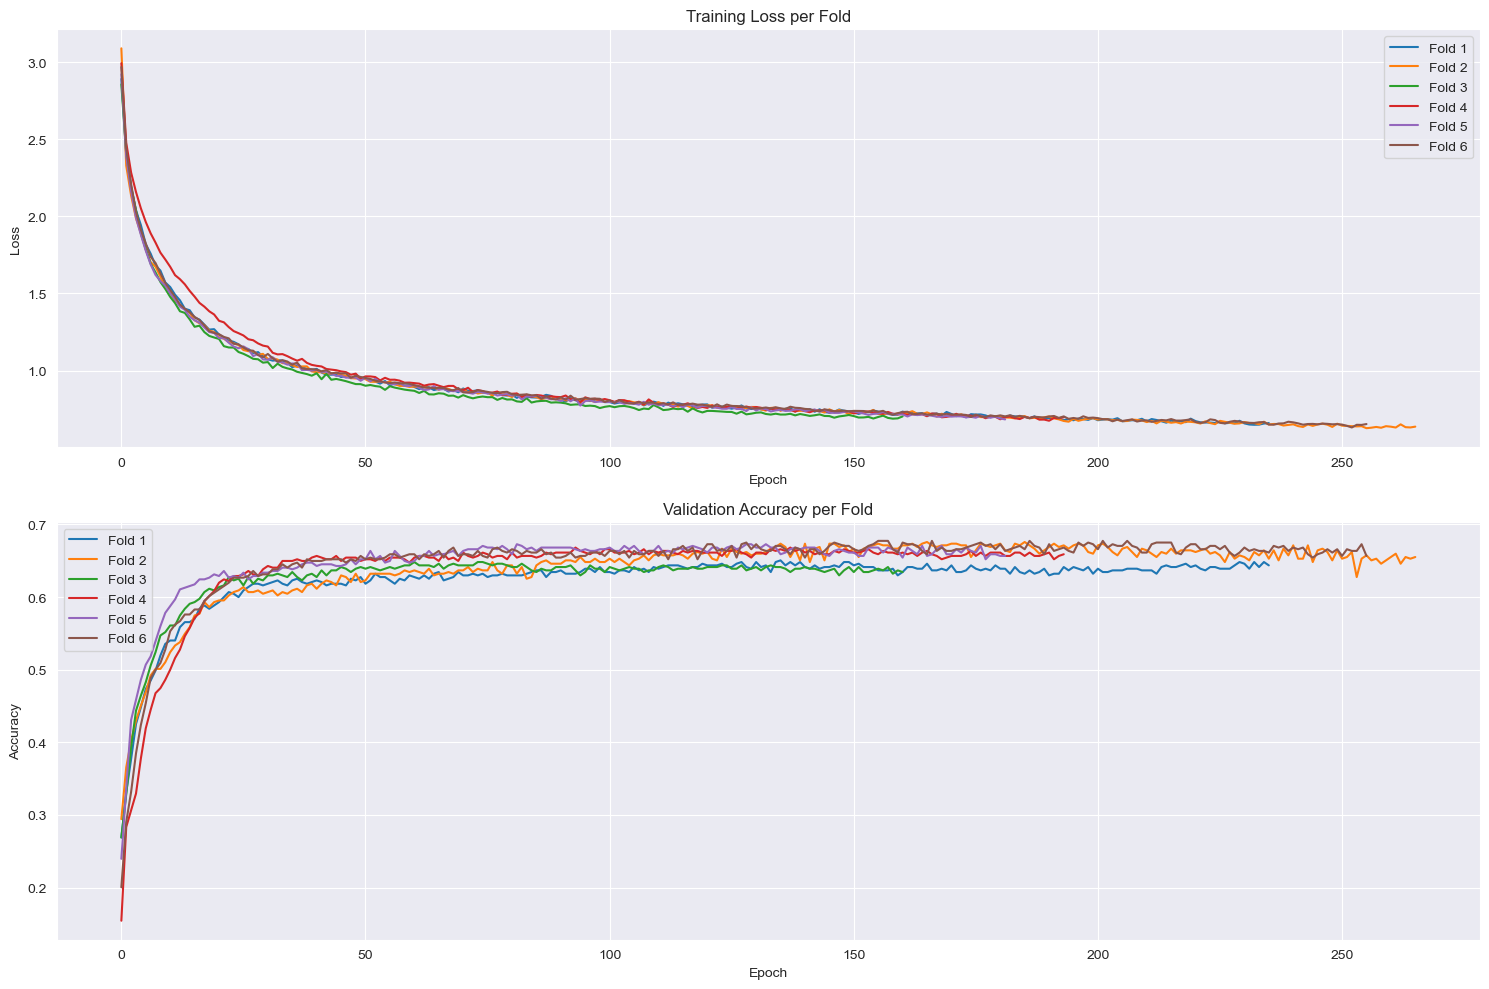

In [27]:
# Train the model
best_model, accuracies, histories = main(train_df)

C:\Users\mihai\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mihai\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mihai\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Model Evaluation on Test Data ===

Overall Test Accuracy: 0.6241

Classification Report:
                   precision    recall  f1-score   support

           Bengal       0.57      0.87      0.69        23
           Birman       0.39      0.39      0.39        18
British Shorthair       0.00      0.00      0.00        16
        Chartreux       0.00      0.00      0.00         3
         European       0.59      0.86      0.70        97
       Maine coon       0.90      1.00      0.95        19
         No breed       0.81      0.28      0.42        46
            Other       0.00      0.00      0.00        13
          Persian       1.00      1.00      1.00        18
          Ragdoll       0.54      0.65      0.59        20
         Savannah       0.00      0.00      0.00         2
          Siamese       1.00      0.20      0.33         5
           Sphynx       1.00      1.00      1.00         7
   Turkish angora       0.00      0.00      0.00         3

         accuracy  

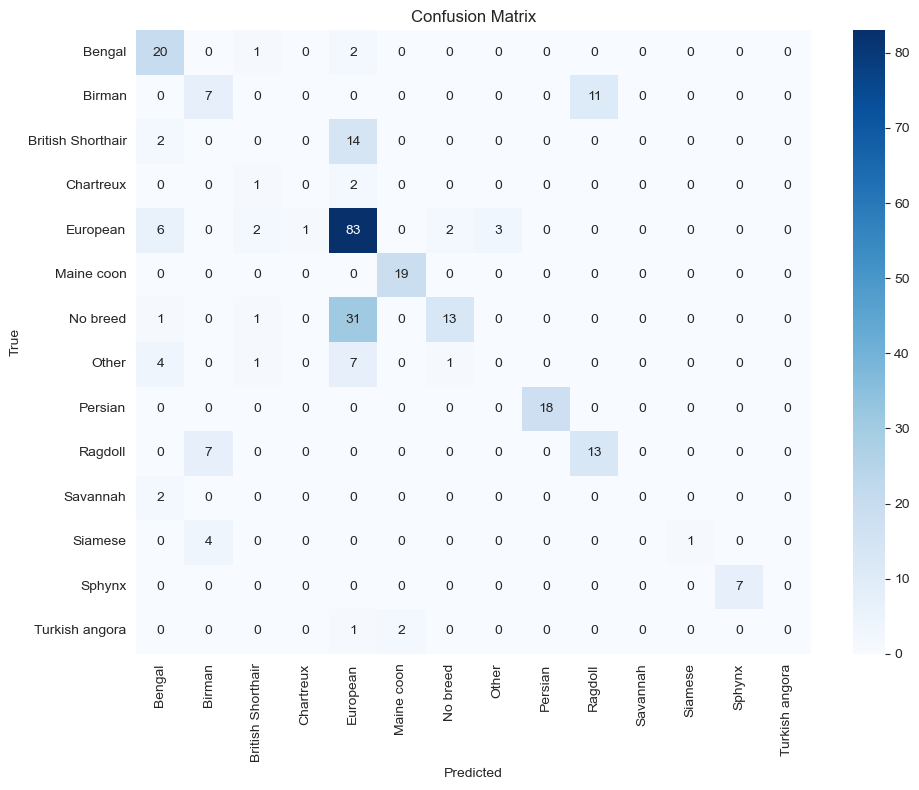

In [28]:
results = evaluate_test_results(test_df, best_model)

> Training a model using a dataset wich is balanced using SMOTE

In [29]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter

def balance_dataset_smote(df, race_counts_dict):
    """
    Balance the dataset using SMOTE according to custom counts for each race.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    race_counts_dict (dict): Dictionary with races as keys and desired counts as values
                            Example: {'European': 500, 'Sphynx': 100, ...}
    
    Returns:
    pandas.DataFrame: Balanced dataset with specified counts for each race
    """
    # Get all race columns
    race_columns = [col for col in df.columns if col.startswith('Race_')]
    
    # Create feature matrix X (excluding race columns)
    feature_columns = [col for col in df.columns if not col.startswith('Race_')]
    X = df[feature_columns]
    
    # Process each race separately
    balanced_dfs = []
    
    for race in race_counts_dict.keys():
        race_col = f'Race_{race}'
        
        if race_col not in df.columns:
            print(f"Warning: {race} not found in dataset. Skipping...")
            continue
            
        # Create binary classification problem for current race
        y = df[race_col].astype(int)
        
        # Calculate sampling strategy
        current_counts = Counter(y)
        desired_count = race_counts_dict[race]
        
        # Only apply SMOTE if we need more samples and have at least one positive sample
        if desired_count > current_counts[1] and current_counts[1] > 0:
            # Calculate ratio to achieve desired count
            sampling_strategy = {1: desired_count}
            
            try:
                # Apply SMOTE
                smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
                X_resampled, y_resampled = smote.fit_resample(X, y)
                
                # Create temporary DataFrame with features
                temp_df = pd.DataFrame(X_resampled, columns=feature_columns)
                
                # Add race columns (all False by default)
                for rc in race_columns:
                    temp_df[rc] = False
                
                # Set current race to True where y_resampled is 1
                temp_df[race_col] = y_resampled == 1
                
                # Only keep positive samples
                temp_df = temp_df[temp_df[race_col]]
                
            except ValueError as e:
                print(f"Warning: SMOTE failed for {race}, using random oversampling instead")
                # Fallback to random oversampling
                temp_df = df[df[race_col]].sample(n=desired_count, replace=True, random_state=42)
                
        else:
            # If we want fewer samples, randomly select without replacement
            n_samples = min(desired_count, current_counts[1])
            temp_df = df[df[race_col]].sample(n=n_samples, random_state=42)
        
        balanced_dfs.append(temp_df)
    
    # Combine all balanced samples
    balanced_df = pd.concat(balanced_dfs, ignore_index=True)
    
    # Print summary of new race distribution
    print("\nNew race distribution:")
    for race in race_counts_dict.keys():
        race_col = f'Race_{race}'
        if race_col in balanced_df.columns:
            count = balanced_df[race_col].sum()
            print(f"{race}: {int(count)}")
    
    return balanced_df

# Example usage:
# Define your desired counts for each race
desired_counts = {
    'European': 800,
    'No breed': 600,
    'Bengal': 500,
    'Ragdoll': 400,
    'Maine coon': 350,
    'Birman': 300,
    'Persian': 300,
    'British Shorthair': 300,
    'Other': 300,
    'Sphynx': 150,
    'Siamese': 100,
    'Chartreux': 60,
    'Turkish angora': 60,
    'Savannah': 50
}

# Balance the dataset
df = balance_dataset_smote(df, desired_counts)


New race distribution:
European: 800
No breed: 600
Bengal: 500
Ragdoll: 400
Maine coon: 350
Birman: 300
Persian: 300
British Shorthair: 300
Other: 300
Sphynx: 150
Siamese: 100
Chartreux: 60
Turkish angora: 60
Savannah: 50


In [30]:
# Split the dataset
train_df, test_df = split_cat_dataset(df, test_size=0.1, random_state=42)

Training set size: 3843 (90.0%)
Test set size: 427 (10.0%)

Race distribution in original dataset:
European             0.187354
No breed             0.140515
Bengal               0.117096
Ragdoll              0.093677
Maine coon           0.081967
Birman               0.070258
Persian              0.070258
British Shorthair    0.070258
Other                0.070258
Sphynx               0.035129
Siamese              0.023419
Chartreux            0.014052
Turkish angora       0.014052
Savannah             0.011710
Name: proportion, dtype: float64

Race distribution in training set:
European             0.187354
No breed             0.140515
Bengal               0.117096
Ragdoll              0.093677
Maine coon           0.081967
British Shorthair    0.070258
Other                0.070258
Birman               0.070258
Persian              0.070258
Sphynx               0.035129
Siamese              0.023419
Turkish angora       0.014052
Chartreux            0.014052
Savannah             0


Fold 1/6
Epoch 5/1000
Train Loss: 1.8978, Train Acc: 0.3948
Val Loss: 1.7798, Val Acc: 0.4477
Epoch 10/1000
Train Loss: 1.4454, Train Acc: 0.5365
Val Loss: 1.3582, Val Acc: 0.5663
Epoch 15/1000
Train Loss: 1.2295, Train Acc: 0.5777
Val Loss: 1.1465, Val Acc: 0.5959
Epoch 20/1000
Train Loss: 1.0614, Train Acc: 0.6151
Val Loss: 1.0304, Val Acc: 0.6053
Epoch 25/1000
Train Loss: 0.9737, Train Acc: 0.6420
Val Loss: 0.9491, Val Acc: 0.6349
Epoch 30/1000
Train Loss: 0.9459, Train Acc: 0.6544
Val Loss: 0.8967, Val Acc: 0.6412
Epoch 35/1000
Train Loss: 0.8815, Train Acc: 0.6736
Val Loss: 0.8580, Val Acc: 0.6599
Epoch 40/1000
Train Loss: 0.8299, Train Acc: 0.6838
Val Loss: 0.8276, Val Acc: 0.6755
Epoch 45/1000
Train Loss: 0.8120, Train Acc: 0.6906
Val Loss: 0.8061, Val Acc: 0.6911
Epoch 50/1000
Train Loss: 0.7918, Train Acc: 0.6986
Val Loss: 0.7900, Val Acc: 0.6864
Epoch 55/1000
Train Loss: 0.7682, Train Acc: 0.7079
Val Loss: 0.7757, Val Acc: 0.6942
Epoch 60/1000
Train Loss: 0.7618, Train Acc: 

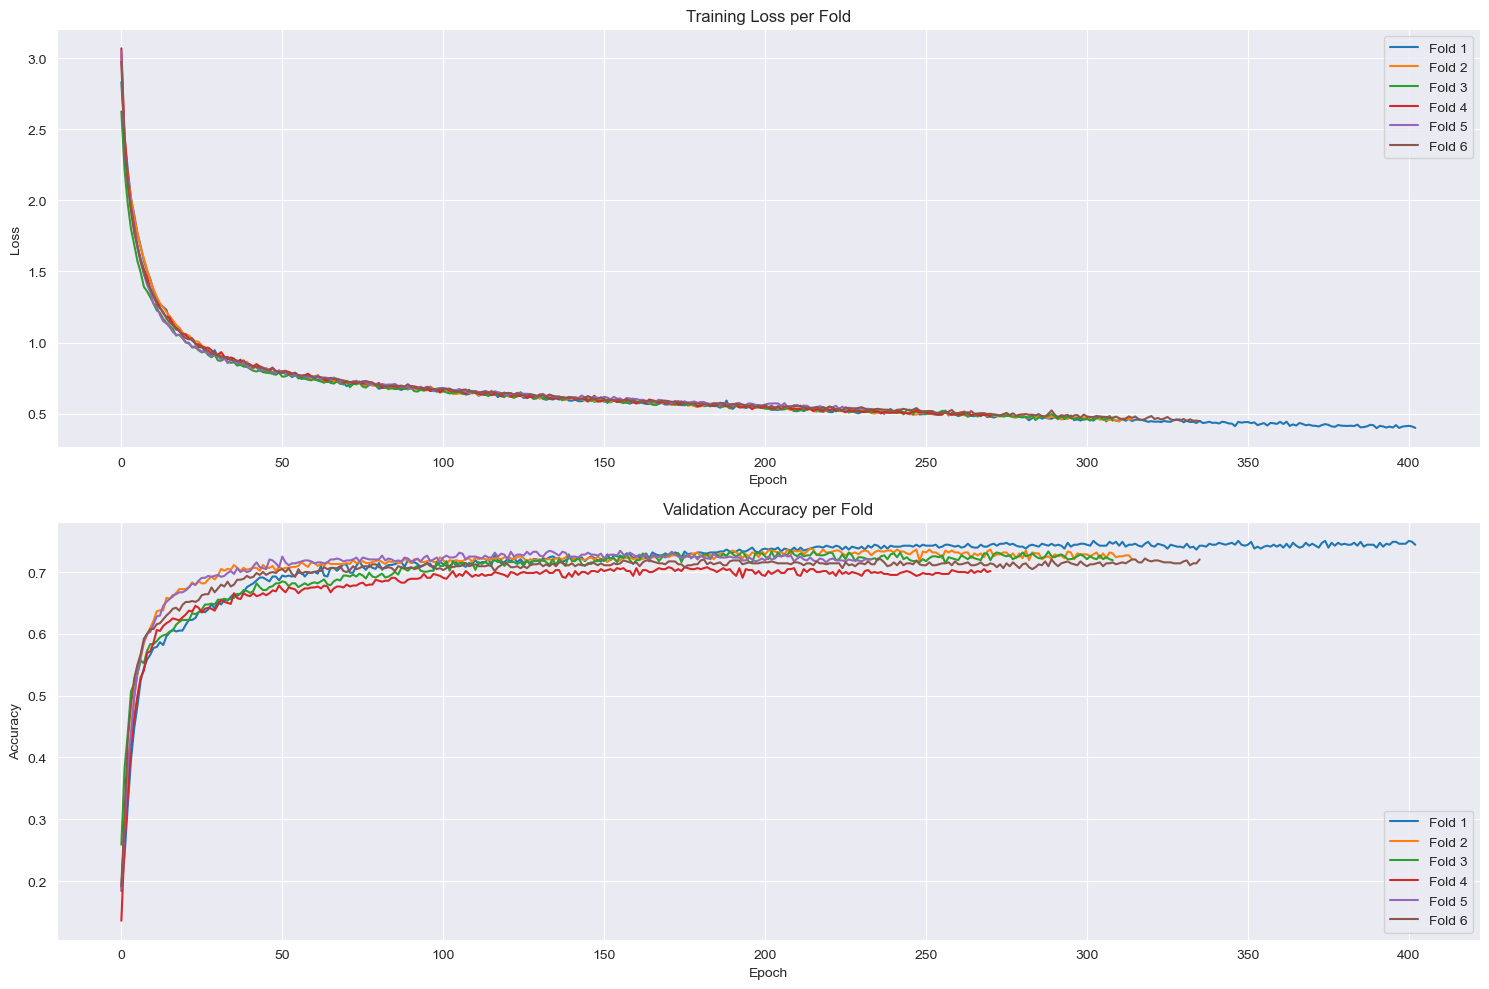

In [31]:
# Train the model
best_model, accuracies, histories = main(train_df)


=== Model Evaluation on Test Data ===

Overall Test Accuracy: 0.7541

Classification Report:
                   precision    recall  f1-score   support

           Bengal       0.71      0.90      0.80        50
           Birman       0.71      0.57      0.63        30
British Shorthair       0.65      0.67      0.66        30
        Chartreux       0.62      0.83      0.71         6
         European       0.67      0.70      0.68        80
       Maine coon       0.97      1.00      0.99        35
         No breed       0.70      0.53      0.60        60
            Other       0.66      0.63      0.64        30
          Persian       1.00      1.00      1.00        30
          Ragdoll       0.73      0.82      0.78        40
         Savannah       1.00      0.20      0.33         5
          Siamese       0.91      1.00      0.95        10
           Sphynx       1.00      1.00      1.00        15
   Turkish angora       1.00      0.67      0.80         6

         accuracy  

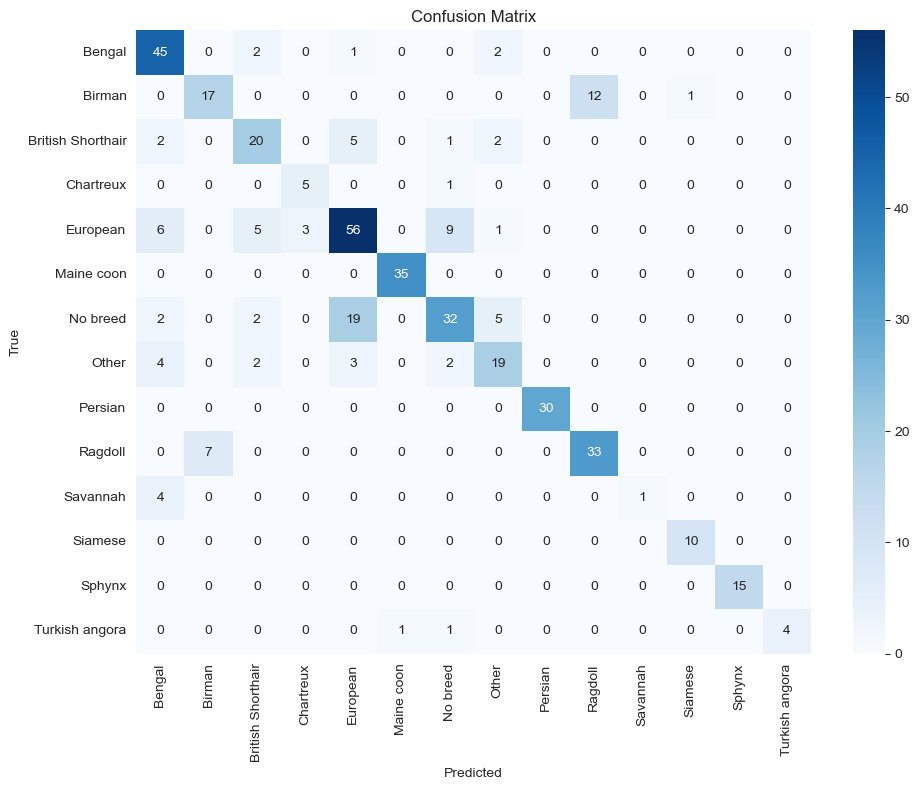

In [32]:
results = evaluate_test_results(test_df, best_model)